# Anomaly Detection and Recommender Systems

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
%matplotlib inline

## 1 Anomaly detection

In [2]:
df = sio.loadmat('ex8data1.mat')
X = df['X']
X_val = df['Xval']
y_val = df['yval'].ravel()

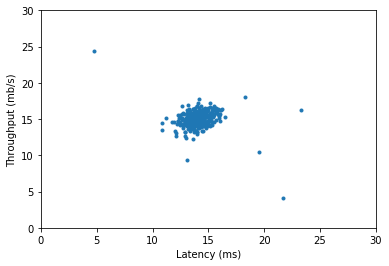

In [3]:
plt.plot(X[:,0], X[:,1], lw=0, marker='.')
plt.xlim([0,30])
plt.ylim([0,30])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

In [4]:
def estimateGaussian(X):
    return np.mean(X, axis=0), np.var(X, axis=0)

In [5]:
mu, sigma2 = estimateGaussian(X)

In [6]:
from scipy.stats import multivariate_normal

In [7]:
X.shape

(307, 2)

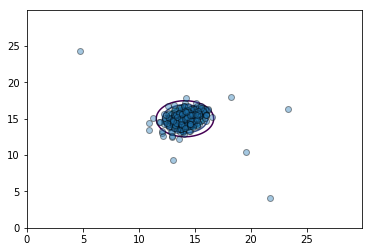

In [8]:
x, y = np.mgrid[0:30:.1, 0:30:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mu, sigma2)
plt.contour(x, y, rv.pdf(pos))
plt.plot(X[:,0], X[:,1], lw=0, marker='o', alpha=0.4, markeredgecolor='black')
plt.show()

In [9]:
p_val = rv.pdf(X_val)

In [10]:
def selectThreshold(y_val, p_val):
    bestF1 = 0.;
    stepsize = (np.max(p_val) - np.min(y_val)) / 1000.0
    for epsilon in np.arange(np.min(p_val), np.max(p_val), stepsize):
        predictions = p_val < epsilon
        tp = np.sum((y_val == 1) & (predictions == 1))
        fp = np.sum((y_val == 1) & (predictions == 0))
        fn = np.sum((y_val == 0) & (predictions == 1))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2.0 * precision * recall / (precision + recall)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
        
            
    return bestEpsilon, bestF1

In [11]:
eps, F1 = selectThreshold(y_val, p_val)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# expect eps = 8.99e-5, F1 = 0.875
eps, F1

(8.990852779269493e-05, 0.8750000000000001)

In [13]:
outliers = np.argwhere(p_val < eps).ravel()

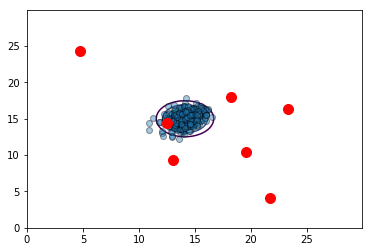

In [14]:
plt.contour(x, y, rv.pdf(pos))
plt.plot(X[:,0], X[:,1], lw=0, marker='o', alpha=0.4, markeredgecolor='black')
plt.plot(X[outliers,0], X[outliers,1], marker='o', lw=0, ms=10, color='red')

In [15]:
df = sio.loadmat('ex8data2.mat')
X = df['X']
X_val = df['Xval']
y_val = df['yval'].ravel()

In [16]:
mu, sigma2 = estimateGaussian(X)

In [17]:
p_val = multivariate_normal(mu, sigma2).pdf(X_val)

In [18]:
eps, F1 = selectThreshold(y_val, p_val)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [19]:
eps, F1

(1.377228890820894e-18, 0.6153846153846154)

In [20]:
print('Outliers: {0}'.format(np.sum(p_val < eps).ravel()))

Outliers: [16]


## 2 Recommender systems



In [21]:
df = sio.loadmat('ex8_movies.mat')
Y = df['Y']
R = df['R']

Average rating for movie 0 (Toy Story)

In [22]:
np.mean(Y[0,R[0,:].astype('bool')])

3.8783185840707963

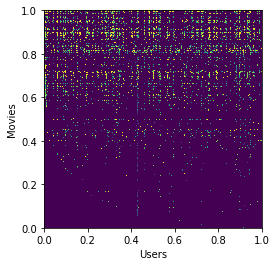

In [23]:
plt.imshow(Y, extent=[0, 1, 0, 1])
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

In [24]:
df = sio.loadmat('ex8_movieParams.mat')
X = df['X']
Theta = df['Theta']
num_users = df['num_users']
num_movies = df['num_movies']
num_features = df['num_features']

In [25]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamb):
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    J = 0.5 * (np.sum(((np.matmul(Theta,X.T)).T - Y)**2 * R) + lamb*np.sum(Theta**2) + lamb*np.sum(X**2))
    return J

In [26]:
# Data is reduced in the original exercise
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies,:num_features]
Theta = Theta[:num_users,:num_features]
Y = Y[:num_movies,:num_users]
R = R[:num_movies,:num_users]
params = np.concatenate((X.ravel(), Theta.ravel()))

In [27]:
# Expect about 22.22
cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)

22.22460372568567

In [28]:
def cofiGradFunc(params, Y, R, num_users, num_movies, num_features, lamb):
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    X_grad = np.zeros((X.shape))
    Theta_grad = np.zeros((Theta.shape))
    for i in range(num_movies):
        X_grad[i,:] = np.matmul(Theta.T, ((np.matmul(Theta, X[i,:].T) - Y[i,:].T) * R[i,:].T).T) + lamb*X[i,:].T
        
    for j in range(num_users):
        Theta_grad[j,:] = np.matmul(X.T, ( (np.matmul(Theta[j,:], X.T) - Y[:,j].T) * R[:,j].T).T) + lamb*Theta[j,:].T
    
    return np.concatenate([X_grad.ravel(), Theta_grad.ravel()])

In [29]:
cofiGradFunc(params, Y, R, num_users, num_movies, num_features, 0)

array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
         3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
        -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
        -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
         4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
        -3.47410789,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])

In [30]:
# Expect about 31.34
cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)

31.344056244274213

In [31]:
with open('movie_ids.txt') as f:
    movieList = [line.strip('\n') for line in f.readlines() ]

In [32]:
my_ratings = np.zeros(len(movieList))

In [33]:
my_ratings[0] = 4.
my_ratings[97] = 2.
my_ratings[6] = 3.
my_ratings[11] = 5.
my_ratings[53] = 4.
my_ratings[63] = 3.
my_ratings[65] = 3.
my_ratings[68] = 5.
my_ratings[182] = 4.
my_ratings[225] = 4.
my_ratings[354] = 5.

In [34]:
df = sio.loadmat('ex8_movies.mat')
Y = df['Y']
R = df['R']

In [35]:
Y = np.hstack([my_ratings.reshape(-1,1), Y])
R = np.hstack([(my_ratings != 0).reshape(-1,1), R])

In [36]:
Ymean = np.zeros(Y.shape[0])
Ynorm = np.zeros(Y.shape)
for i in range(Y.shape[0]):
    idx = R[i,:] == 1
    Ymean[i] = np.mean(Y[i, idx])
    Ynorm[i, idx] = Y[i, idx] - Ymean[i]

In [37]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [38]:
from scipy.optimize import minimize
theta = np.random.randn(num_movies, num_features)
X = np.random.randn(num_users, num_features)
x0 = np.hstack([X.ravel(), theta.ravel()])
l = 10.
minimize_result = minimize(cofiCostFunc, x0, method="CG", 
                           jac=cofiGradFunc, args=(Ynorm, R, num_users, num_movies, num_features, l), 
                           options={"maxiter": 100})

In [39]:
X = minimize_result.x[:num_movies*num_features].reshape(num_movies, num_features)
Theta = minimize_result.x[num_movies*num_features:].reshape(num_users, num_features)

In [40]:
p = np.matmul(X, Theta.T)

In [41]:
p.shape

(1682, 944)

My predictions, since my ratings were added to the beginning of the array.

In [42]:
mypredictions = p[:,0] + Ymean

In [43]:
for i in np.argsort(mypredictions)[::-1][:10]:
    print('{0:.1f} {1}'.format(mypredictions[i], movieList[i]))

5.0 Santa with Muscles (1996)
5.0 Entertaining Angels: The Dorothy Day Story (1996)
5.0 Someone Else's America (1995)
5.0 Aiqing wansui (1994)
5.0 Great Day in Harlem, A (1994)
5.0 Saint of Fort Washington, The (1993)
5.0 They Made Me a Criminal (1939)
5.0 Marlene Dietrich: Shadow and Light (1996) 
5.0 Prefontaine (1997)
5.0 Star Kid (1997)


In [44]:
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(my_ratings[i], movieList[i])

4.0 Toy Story (1995)
3.0 Twelve Monkeys (1995)
5.0 Usual Suspects, The (1995)
4.0 Outbreak (1995)
3.0 Shawshank Redemption, The (1994)
3.0 While You Were Sleeping (1995)
5.0 Forrest Gump (1994)
2.0 Silence of the Lambs, The (1991)
4.0 Alien (1979)
4.0 Die Hard 2 (1990)
5.0 Sphere (1998)
